<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/review_processing_2020_02_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
cd '/gdrive/My Drive/abv_reviews'

/gdrive/My Drive/abv_reviews


In [3]:
!pip install -U spacy[cuda100]

     |████████████████████████████████| 10.4MB 7.5MB/s 
     |████████████████████████████████| 122kB 39.4MB/s 
     |████████████████████████████████| 3.7MB 41.6MB/s 
     |████████████████████████████████| 2.2MB 48.7MB/s 
     |████████████████████████████████| 382.9MB 48kB/s 
  Found existing installation: preshed 2.0.1
    Uninstalling preshed-2.0.1:
      Successfully uninstalled preshed-2.0.1
  Found existing installation: blis 0.2.4
    Uninstalling blis-0.2.4:
      Successfully uninstalled blis-0.2.4
  Found existing installation: thinc 7.0.8
    Uninstalling thinc-7.0.8:
      Successfully uninstalled thinc-7.0.8
  Found existing installation: spacy 2.1.9
    Uninstalling spacy-2.1.9:
      Successfully uninstalled spacy-2.1.9


In [4]:
!pip install textdistance
!pip install "textdistance[extras]"

     |████████████████████████████████| 143kB 6.9MB/s 
     |████████████████████████████████| 890kB 22.3MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyxDamerauLevenshtein: filename=pyxDamerauLevenshtein-1.5.3-cp36-cp36m-linux_x86_64.whl size=86819 sha256=cb0b6d8335ddfb8a44a57760e41df1ca7e7d1a03243e8fd77b6d4d5d7f0f3e73
  Stored in directory: /root/.cache/pip/wheels/37/66/2c/863e33407d169ea809ce2908e86556df205dcf5edc4bdd10a5
Successfully built pyxDamerauLevenshtein
  Created wheel for jellyfish: filename=jellyfish-0.7.2-cp36-cp36m-linux_x86_64.whl size=72997 sha256=38e2860ddb9083f00b4bc1f30d17e9e871a91740a9e46bc37dfdde70e66ea38b
  Stored in directory: /root/.cache/pip/wheels/e8/fe/99/d8fa8f2ef7b82a625b0b77a84d319b0b50693659823c4effb4
  Created wheel for python-Levenshtein: fi

In [5]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
import random
import srsly
import json
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from spacy import displacy
from spacy.util import minibatch, compounding, decaying
from pandas.io.json import json_normalize
from spacy.gold import docs_to_json, biluo_tags_from_offsets, offsets_from_biluo_tags
from spacy.matcher import Matcher 
from spacy.tokens import Span

import itertools
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [7]:
spacy.prefer_gpu()

True

In [0]:
def cleanse_text(text):
  step1 = re.sub(r"(\{'LOWER':\s)",r"",str(text))
  step2 = re.sub(r"[\[{\'\,\"}\]]",r"",step1)
  return step2

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']

#        print(text, annotations)
        valid_entities = []
        for start, end, label in entities:
          valid_start = start
          valid_end = end
#          print(valid_start, valid_end, len(text))
          while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):
            valid_start += 1
          while valid_end > 1 and invalid_span_tokens.match(text[valid_end - 1]):
            valid_end -= 1
          valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])

    return cleaned_data

def dump_jsonl(data, output_path, append=False):
    """
    Write list of objects to a JSON lines file.
    """
    mode = 'a+' if append else 'w'
    with open(output_path, mode, encoding='utf-8') as f:
        for line in data:
            json_record = json.dumps(line, ensure_ascii=False)
            f.write(json_record + '\n')
    print('Wrote {} records to {}'.format(len(data), output_path))

def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data


def create_entity_pattern(ent_name, ent_label):
  pattern_list = []
  pattern_dict = {}
  id_str = ''
  for word in ent_name.lower().split():
    token_dict = {}
    token_dict['LOWER'] = word
    pattern_list.append(token_dict)
    id_str += '_' + word
  if ent_label[:2] == 'U_':
    pattern_dict['label'] = ent_label[2:]
  else:
    pattern_dict['label'] = ent_label  
  pattern_dict['pattern'] = pattern_list
  if id_str[0] == '_':
    id_str = id_str[1:]
  pattern_dict['id'] = id_str
  return pattern_dict


def clean_like_objects(text):
  step1 = re.sub("ObjectId\(\'","",str(text))
  step2 = re.sub("\'\)","",step1)
  return step2


In [0]:
!cat beverage.jsonl bread.jsonl card_date_event_fac.jsonl > test1.jsonl
!cat condiment.jsonl dish.jsonl event_food_habit.jsonl > test2.jsonl
!cat fruit.jsonl herb_lifestyle_meal.jsonl loc_money_norp_ordinal.jsonl > test3.jsonl
!cat org_product.jsonl pastry_seed_spice.jsonl quant_time.jsonl vegetable.jsonl > test4.jsonl
!cat test1.jsonl test2.jsonl test3.jsonl test4.jsonl > test5.jsonl
!cat test5.jsonl updated_GPE.jsonl > patterns_2020_02_04.jsonl

In [0]:
df_temp = pd.read_json('patterns_2020_02_04.jsonl',lines=True)

In [11]:
df_pattern = pd.read_json('patterns_2020_02_04.jsonl',lines=True)
df_pattern['cleaned_pattern'] = df_pattern.pattern.apply(lambda x: cleanse_text(x))
df_pattern['label'] = 'U_' + df_pattern.label.astype(str)
df_pattern['tup_col'] = list(zip(df_pattern.cleaned_pattern, df_pattern.label))
df_pattern['merged'] = df_pattern.apply(lambda row: {row['cleaned_pattern']:row['label']}, axis=1)
df_pattern.head()
df_pattern.tail()

,label,pattern,id,cleaned_pattern,tup_col,merged
22032,U_GPE_region,[{'LOWER': 'šumadija'}],šumadija,šumadija,"(šumadija, U_GPE_region)",{'šumadija': 'U_GPE_region'}
22033,U_GPE_region,"[{'LOWER': 'žilina'}, {'LOWER': 'region'}]",žilina_region,žilina region,"(žilina region, U_GPE_region)",{'žilina region': 'U_GPE_region'}
22034,U_GPE_region,[{'LOWER': 'ǁkaras'}],ǁkaras,ǁkaras,"(ǁkaras, U_GPE_region)",{'ǁkaras': 'U_GPE_region'}
22035,U_GPE_region,"[{'LOWER': 'șoldănești'}, {'LOWER': 'district'}]",șoldănești_district,șoldănești district,"(șoldănești district, U_GPE_region)",{'șoldănești district': 'U_GPE_region'}
22036,U_GPE_region,"[{'LOWER': 'ștefan'}, {'LOWER': 'vodă'}, {'LOW...",ștefan_vodă_district,ștefan vodă district,"(ștefan vodă district, U_GPE_region)",{'ștefan vodă district': 'U_GPE_region'}


In [0]:
ent_list = df_pattern.tup_col.to_list()

In [0]:
nlp = en_core_web_lg.load()

In [14]:
ruler = EntityRuler(nlp).from_disk("patterns_2020_02_04.jsonl")
nlp.add_pipe(ruler, before='ner')
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')
nlp.pipe_names

['tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [15]:
reviews = pd.read_csv('full_reviews.csv',usecols=['_id', 'createdAt','text',\
                                                  'overall','originality','value','nutrition','presentation','taste',\
                                                  'type','user','user_info.name','user_info.username','user_info.home',\
                                                  'user_info.language','user_info.reviewKarma.total.score',\
                                                  'user_info.likedArticlesCount','user_info.likedReviewsCount',\
                                                  'user_info.followersCount','user_info.challengeReviews',\
                                                  'dish','dish_info.name','type',\
                                                  'restaurant','restaurant_name','restaurant_website','restaurant_country','restaurant_locality',\
                                                  'likes'])
reviews['createdAt'] = pd.to_datetime(reviews['createdAt'],format='%Y-%m-%d %H:%M:%S.%f')

reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92797 entries, 0 to 92796
Data columns (total 28 columns):
_id                                  92797 non-null object
likes                                92797 non-null object
user                                 92797 non-null object
text                                 92797 non-null object
type                                 92797 non-null object
restaurant                           92797 non-null object
dish                                 92797 non-null object
taste                                92797 non-null int64
presentation                         92797 non-null int64
nutrition                            92797 non-null int64
originality                          92797 non-null int64
value                                92797 non-null int64
overall                              92797 non-null float64
createdAt                            92797 non-null datetime64[ns]
user_info.name                       92797 non-null object
us

In [0]:
train_reviews = reviews[:3000]
eval_reviews = reviews[3000:92500]
test_reviews = reviews[92500:]

In [0]:
train_gen = (rev for rev in train_reviews['text'])
to_train_ents = []
check_list = []

In [0]:
for raw, doc in zip(list(train_reviews['text']), nlp.pipe(list(train_reviews['text']))):
  tok_list = [token.text for token in doc]
  tag_list = ['O' for token in doc]
  matched_ents = [(i,item) for i, item in enumerate(tok_list) if item.lower() in [i[0] for i in ent_list + check_list]]

  for ent in matched_ents:
    ent_tag = ''.join(list(set([tup[1] for tup in ent_list + check_list if tup[0] == ent[1].lower()])))
    tag_list[ent[0]] = ent_tag
  entities = offsets_from_biluo_tags(doc, tag_list)
  to_train_ents.append((raw, dict(entities = entities)))
clean_train_ents = trim_entity_spans(to_train_ents)

In [19]:
dump_jsonl(clean_train_ents,'train.jsonl')

Wrote 3000 records to train.jsonl


In [20]:
train_data = load_jsonl('train.jsonl')
type(train_data)

Loaded 3000 records from train.jsonl


list

In [21]:
model = 'en_core_web_lg'
#model = None


"""Load the model, set up the pipeline and train the entity recognizer."""
if model is not None:
    nlp = en_core_web_lg.load()  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")

# nlp.create_pipe works for built-ins that are registered with spaCy
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe("ner")

# add labels
for _, annotations in train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

Loaded model 'en_core_web_lg'


In [22]:
ner.labels

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'GPE_city',
 'GPE_cityU_GPE_region',
 'GPE_country',
 'GPE_region',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART',
 'beverage',
 'bread',
 'condiment',
 'dish',
 'dishU_spice',
 'food_habit',
 'fruit',
 'herb',
 'lifestyle',
 'meal',
 'pastry',
 'seed',
 'spice',
 'vegetable')

In [0]:
dropout = decaying(0.6, 0.2, 1e-4)

In [0]:
# get names of other pipes to disable them during training
#other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner", "entity_ruler","merge_entities"]]

other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner"]]

loss_trend = []
with nlp.disable_pipes(*other_pipes):  # only train NER
    # reset and initialize the weights randomly – but only if we're
    # training a new model
    if model is None:
        nlp.begin_training()



    for itn in range(40):
      random.shuffle(train_data)
      losses = {}

#      for item in clean_train_ents:
# batch up the examples using spaCy's minibatch
      batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))

      for batch in batches:
        texts, annotations = zip(*batch)
#        print([item[0]], [item[1]])

#        print(texts)
#        print(annotations)
        nlp.update(texts, annotations, drop=next(dropout), losses=losses)
        loss_trend.append(losses['ner'])

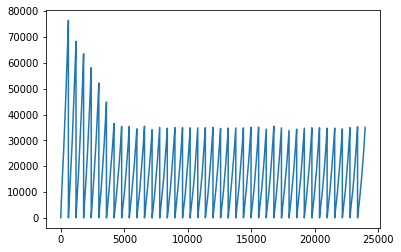

In [25]:
plt.plot(loss_trend)

In [26]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [27]:
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')
ruler = EntityRuler(nlp).from_disk("patterns_2020_02_04.jsonl")
nlp.add_pipe(ruler, before='ner')
nlp.pipe_names

['tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [0]:
nlp.to_disk('trained_model_2020_02_04')

In [0]:
nlp = spacy.load('trained_model_2020_02_04')

In [17]:
ent_list_eval = []
for doc in nlp.pipe(eval_reviews['text']):
#  displacy.render(nlp(doc),'ent',jupyter=True)
  ent_list_eval.append([k  for k in Counter(sorted([(ent.ent_id_) for ent in doc.ents if ent.ent_id_ != ''])).keys()])
#ent_list.append([ent.text for ent in nlp(doc).ents if ent.ent_id_ == ''])

ent_list_eval[-5:]

[['10',
  'avocado',
  'beans',
  'cilantro',
  'corn',
  'hummus',
  'lunch',
  'today',
  'tomatoes',
  'tortilla_bread',
  'vegan',
  'wrap'],
 ['egg', 'miso', 'noodles', 'ramen', 'soy_bean', 'vegan'],
 ['egg', 'miso', 'noodles', 'ramen', 'soy_bean', 'vegan'],
 ['99_%', 'butter', 'cheese', 'chicago', 'tomato_sauce', 'vegan', 'vegetable'],
 ['99_%', 'butter', 'cheese', 'chicago', 'tomato_sauce', 'vegan', 'vegetable']]

In [18]:
ent_list_eval[:5]

[['meat', 'sausage', 'sausage_roll', 'vegan'],
 [],
 [],
 ['jelly', 'sugar'],
 ['broccolini', 'entrée', 'vegan']]

In [0]:
df_entities = pd.DataFrame(pd.Series(ent_list_eval),columns=['entities'])

In [0]:
df_entities.to_csv('entities_10_90k.csv')

In [21]:
df_entities.tail()

,entities
79995,"[10, avocado, beans, cilantro, corn, hummus, l..."
79996,"[egg, miso, noodles, ramen, soy_bean, vegan]"
79997,"[egg, miso, noodles, ramen, soy_bean, vegan]"
79998,"[99_%, butter, cheese, chicago, tomato_sauce, ..."
79999,"[99_%, butter, cheese, chicago, tomato_sauce, ..."


In [22]:
eval_reviews.reset_index(drop=True)

,_id,likes,user,text,type,restaurant,dish,taste,presentation,nutrition,originality,value,overall,createdAt,user_info.name,user_info.likedArticlesCount,user_info.followersCount,user_info.likedReviewsCount,user_info.challengeReviews,user_info.language,user_info.reviewKarma.total.score,dish_info.name,restaurant_name,restaurant_country,restaurant_website,restaurant_locality
0,5e1db388f5e9b50020778794,"[ObjectId('5c3530801b78330004aa6dc6'), ObjectI...",5dee900b5098f40020f128cd,The Greggs vegan sausage rolls are so lush! Th...,dish,5e172abedfb870002086eb7a,5e19e2e6ce56f60020488512,5,5,4,4,5,4.6,2020-01-14 12:26:48.486,whatrebeccaeats,0,3,4,4,en,4,Vegan Sausage Roll,Greggs,United Kingdom,https://www.greggs.co.uk/,NaN
1,5e1db339f5e9b50020778786,[ObjectId('5c748a8934dda90004b017b4')],5d321bee40e1b300049613c9,Calentar el pan no hubiera estado mal! Muy log...,dish,5c6fae8676f4630004a99715,5ded82e9b9fe1300207a847f,4,4,3,4,4,3.8,2020-01-14 12:25:29.182,sechague,0,5,15,21,es,24,Hamburguesa Le Bleu,Casa Mhia,Argentina,http://www.facebook.com/casamhia/,NaN
2,5e1db2dbf2316f0020a86169,"[ObjectId('5c3530801b78330004aa6dc6'), ObjectI...",5d321bee40e1b300049613c9,"Muy rica la salchicha, quizás hubiera faltado ...",dish,5c6fae8676f4630004a99715,5ded141fb9fe1300207a617b,4,4,3,4,4,3.8,2020-01-14 12:23:55.409,sechague,0,5,15,21,es,24,pancho Alemán,Casa Mhia,Argentina,http://www.facebook.com/casamhia/,NaN
3,5e1db28af2316f0020a86157,"[ObjectId('5bdc175f39e739000445ab2c'), ObjectI...",5c9d5576c0918c000425c391,Definitely my fave tau huey around! Decided to...,dish,5abc818231bca50004707143,5e1db289f5e9b50020778761,4,3,3,3,4,3.4,2020-01-14 12:22:34.181,ycarolyn,0,54,448,14,en,199,Classic Beancurd And Grass Jelly,Mr Bean - HarbourFront Centre,Singapore,http://www.mrbean.com.sg/,Singapore
4,5e1db24ff5e9b5002077874c,"[ObjectId('5c3530801b78330004aa6dc6'), ObjectI...",5e11c7f7e5988d00203a7bc0,Flavour was amazing! So rich and luxurious. Be...,dish,5cad0305cb483a0004b22465,5e1db24ef2316f0020a8614b,5,5,4,3,3,4.0,2020-01-14 12:21:35.345,mally,0,0,0,2,en,2,Soft Polenta with Mushroom and Vegetable Ragu,Onesta Cucina,Australia,http://www.onestacucina.com.au/,Bowral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,5af63563fa97fd0004f688a1,[ObjectId('5982cb71dd779100040214f7')],5ac53ef6874bdd000481f665,I had this delicious vegan wrap today for lunc...,dish,5ac55a3f874bdd000481f6eb,5af63562fa97fd0004f688a0,5,5,5,5,5,5.0,2018-05-12 00:29:23.744,Shaning Bourdon,0,7,0,7,NaN,0,Roll up (veggie),Delicado's,Canada,http://www.delicados-deli.com/,Nanaimo
79996,5af624e9fa97fd0004f68899,"[ObjectId('59c489e73e616a0004f9bcf7'), ObjectI...",59c489e73e616a0004f9bcf7,So inspiring! This is one of the few places I’...,dish,5af61f6efa97fd0004f68895,5af624e8fa97fd0004f68898,5,5,5,5,5,5.0,2018-05-11 23:19:05.439,Vikas Garg,153,696,8637,37,en,661,Vegan Ramen,Kirimachi Ramen,United States,http://www.kirimachi.com/,San Francisco
79997,5af624e9fa97fd0004f68899,"[ObjectId('59c489e73e616a0004f9bcf7'), ObjectI...",59c489e73e616a0004f9bcf7,So inspiring! This is one of the few places I’...,dish,5af61f6efa97fd0004f68895,5af624e8fa97fd0004f68898,5,5,5,5,5,5.0,2018-05-11 23:19:05.439,Vikas Garg,153,696,8637,37,en,661,Vegan Ramen,Kirimachi Ramen,United States,http://www.kirimachi.com/,San Francisco
79998,5af61aa6fa97fd0004f68885,"[ObjectId('5982cb71dd779100040214f7'), ObjectI...",59c489e73e616a0004f9bcf7,OMG this was literally divine. I haven’t had C...,dish,5af61933fa97fd0004f68880,5af61aa5fa97fd0004f68884,5,5,2,5,4,4.2,2018-05-11 22:35:18.387,Vikas Garg,153,696,8637,37,en,661,Vegetarian Deep Dish Pizza,Little Star Pizza,United States,http://littlestarvalencia.com/,San Francisco


In [23]:
eval_new_df = pd.concat([eval_reviews.reset_index(drop=True), df_entities],axis=1,ignore_index=True)
eval_new_df.columns = list(eval_reviews.columns) + list(df_entities.columns)
eval_new_df.head()

,_id,likes,user,text,type,restaurant,dish,taste,presentation,nutrition,originality,value,overall,createdAt,user_info.name,user_info.likedArticlesCount,user_info.followersCount,user_info.likedReviewsCount,user_info.challengeReviews,user_info.language,user_info.reviewKarma.total.score,dish_info.name,restaurant_name,restaurant_country,restaurant_website,restaurant_locality,entities
0,5e1db388f5e9b50020778794,"[ObjectId('5c3530801b78330004aa6dc6'), ObjectI...",5dee900b5098f40020f128cd,The Greggs vegan sausage rolls are so lush! Th...,dish,5e172abedfb870002086eb7a,5e19e2e6ce56f60020488512,5,5,4,4,5,4.6,2020-01-14 12:26:48.486,whatrebeccaeats,0,3,4,4,en,4,Vegan Sausage Roll,Greggs,United Kingdom,https://www.greggs.co.uk/,NaN,"[meat, sausage, sausage_roll, vegan]"
1,5e1db339f5e9b50020778786,[ObjectId('5c748a8934dda90004b017b4')],5d321bee40e1b300049613c9,Calentar el pan no hubiera estado mal! Muy log...,dish,5c6fae8676f4630004a99715,5ded82e9b9fe1300207a847f,4,4,3,4,4,3.8,2020-01-14 12:25:29.182,sechague,0,5,15,21,es,24,Hamburguesa Le Bleu,Casa Mhia,Argentina,http://www.facebook.com/casamhia/,NaN,[]
2,5e1db2dbf2316f0020a86169,"[ObjectId('5c3530801b78330004aa6dc6'), ObjectI...",5d321bee40e1b300049613c9,"Muy rica la salchicha, quizás hubiera faltado ...",dish,5c6fae8676f4630004a99715,5ded141fb9fe1300207a617b,4,4,3,4,4,3.8,2020-01-14 12:23:55.409,sechague,0,5,15,21,es,24,pancho Alemán,Casa Mhia,Argentina,http://www.facebook.com/casamhia/,NaN,[]
3,5e1db28af2316f0020a86157,"[ObjectId('5bdc175f39e739000445ab2c'), ObjectI...",5c9d5576c0918c000425c391,Definitely my fave tau huey around! Decided to...,dish,5abc818231bca50004707143,5e1db289f5e9b50020778761,4,3,3,3,4,3.4,2020-01-14 12:22:34.181,ycarolyn,0,54,448,14,en,199,Classic Beancurd And Grass Jelly,Mr Bean - HarbourFront Centre,Singapore,http://www.mrbean.com.sg/,Singapore,"[jelly, sugar]"
4,5e1db24ff5e9b5002077874c,"[ObjectId('5c3530801b78330004aa6dc6'), ObjectI...",5e11c7f7e5988d00203a7bc0,Flavour was amazing! So rich and luxurious. Be...,dish,5cad0305cb483a0004b22465,5e1db24ef2316f0020a8614b,5,5,4,3,3,4.0,2020-01-14 12:21:35.345,mally,0,0,0,2,en,2,Soft Polenta with Mushroom and Vegetable Ragu,Onesta Cucina,Australia,http://www.onestacucina.com.au/,Bowral,"[broccolini, entrée, vegan]"


In [24]:
ent_list_eval_tba = []
for doc in nlp.pipe(eval_reviews['text']):
  ent_list_eval_tba.append([ent.text for ent in doc.ents if ent.ent_id_ == ''])

df_eval = pd.DataFrame()
df_eval = df_eval.append(ent_list_eval_tba).dropna(how='all')

full_list_eval_tba = []

for col in df_eval.columns:
  full_list_eval_tba.extend([k.lower() for k in Counter(list(df_eval[col])).keys() if k != None])

full_list_eval_tba = [k for k in Counter(sorted(full_list_eval_tba)).keys()]
len(full_list_eval_tba)

1112

In [25]:
ent_list_test_tba = []
for doc in nlp.pipe(test_reviews['text']):
  ent_list_test_tba.append([ent.text for ent in doc.ents if ent.ent_id_ == ''])

df_test = pd.DataFrame()
df_test = df_test.append(ent_list_test_tba).dropna(how='all')

full_list_test_tba = []

for col in df_test.columns:
  full_list_test_tba.extend([k.lower() for k in Counter(list(df_test[col])).keys() if k != None])

full_list_test_tba = [k for k in Counter(sorted(full_list_test_tba)).keys()]
len(full_list_test_tba)

86

In [26]:
entities_to_be_added = [k for k in Counter(sorted(full_list_eval_tba + full_list_test_tba)).keys()]
len(entities_to_be_added)

1134

In [0]:
import textdistance as td

In [0]:
pat_list = list(df_pattern['id'].unique())

In [29]:
leven_result = []
for inp in entities_to_be_added:

  for pat in pat_list:
    leven = td.levenshtein.normalized_similarity(inp, pat)

    if  (leven > 0.7) & (leven < 0.9999):
      leven_result.append((inp, pat, leven))
len(leven_result)

837

In [30]:
leven_result.sort(key=lambda x: x[0])
leven_result

[('1.50/100', '10/100', 0.75),
 ('10.5', '10/5', 0.75),
 ('1000/10', '10000', 0.7142857142857143),
 ('1000/10', '10/10', 0.7142857142857143),
 ('1000/10', '100/10', 0.8571428571428572),
 ('1001', '1000', 0.75),
 ('1001', '100', 0.75),
 ('1001', '100x', 0.75),
 ('16month', 'month', 0.7142857142857143),
 ('1:00', '1000', 0.75),
 ('1:00', '100', 0.75),
 ('1:00', '5:00', 0.75),
 ('1:30', '5:30', 0.75),
 ('1:30', '7:30', 0.75),
 ('20/20', '20/10', 0.8),
 ('3/11', '3/10', 0.75),
 ('30mins', '10_mins', 0.7142857142857143),
 ('30mins', '20_mins', 0.7142857142857143),
 ('30mins', '90_mins', 0.7142857142857143),
 ('5-spice', 'spice', 0.7142857142857143),
 ('50,000', '50000', 0.8333333333333334),
 ('60th', '10th', 0.75),
 ('60th', '20th', 0.75),
 ('60th', '30th', 0.75),
 ('60th', '6th', 0.75),
 ('60th', '90th', 0.75),
 ('6:00', '5:00', 0.75),
 ('7000', '1000', 0.75),
 ('7000', '3000', 0.75),
 ('adai', 'ada', 0.75),
 ('addis', 'raddish', 0.7142857142857143),
 ('afuri', 'akuri', 0.8),
 ('afuri', 'a

In [0]:
with open('entities_to_be_added_test.txt', 'w') as f:
    f.write(json.dumps(entities_to_be_added))

with open('most_similar_patterns.txt', 'w') as f:
    f.write(json.dumps(leven_result))


In [35]:
eval_new_df.columns

Index(['review', 'likes', 'user', 'text', 'type', 'restaurant', 'dish',
       'taste', 'presentation', 'nutrition', 'originality', 'value', 'overall',
       'createdAt', 'user_name', 'user_likedArticlesCount',
       'user_followersCount', 'user_likedReviewsCount',
       'user_challengeReviews', 'user_language', 'user_reviewKarma_score',
       'dish_name', 'restaurant_name', 'restaurant_country',
       'restaurant_website', 'restaurant_locality', 'entities'],
      dtype='object')

In [0]:
eval_new_df.columns = ['review', 'likes', 'user', 'text', 'type', 'restaurant', 'dish', 'taste',\
                       'presentation', 'nutrition', 'originality', 'value', 'overall',\
                       'createdAt', 'user_name', 'user_likedArticlesCount', 'user_followersCount',\
                       'user_likedReviewsCount','user_challengeReviews', 'user_language',\
                       'user_reviewKarma_score', 'dish_name', 'restaurant_name', 'restaurant_country', \
                       'restaurant_website', 'restaurant_locality', 'entities']

In [37]:
df_likes = eval_new_df[['review','likes']]
df_likes['cleaned_likes'] = df_likes['likes'].apply(lambda x: clean_like_objects(x))
df_likes.head()

,review,likes,cleaned_likes
0,5e1db388f5e9b50020778794,"[ObjectId('5c3530801b78330004aa6dc6'), ObjectI...","[5c3530801b78330004aa6dc6, 5df5528a261f8300207..."
1,5e1db339f5e9b50020778786,[ObjectId('5c748a8934dda90004b017b4')],[5c748a8934dda90004b017b4]
2,5e1db2dbf2316f0020a86169,"[ObjectId('5c3530801b78330004aa6dc6'), ObjectI...","[5c3530801b78330004aa6dc6, 5e03e8307956290020e..."
3,5e1db28af2316f0020a86157,"[ObjectId('5bdc175f39e739000445ab2c'), ObjectI...","[5bdc175f39e739000445ab2c, 5d4fc4bec470910004c..."
4,5e1db24ff5e9b5002077874c,"[ObjectId('5c3530801b78330004aa6dc6'), ObjectI...","[5c3530801b78330004aa6dc6, 5e03e8307956290020e..."


In [38]:
df_likes['likes'] = df_likes.cleaned_likes.apply(lambda x: x[1:-1].split(','))
df_likes.head()

,review,likes,cleaned_likes
0,5e1db388f5e9b50020778794,"[5c3530801b78330004aa6dc6, 5df5528a261f830020...","[5c3530801b78330004aa6dc6, 5df5528a261f8300207..."
1,5e1db339f5e9b50020778786,[5c748a8934dda90004b017b4],[5c748a8934dda90004b017b4]
2,5e1db2dbf2316f0020a86169,"[5c3530801b78330004aa6dc6, 5e03e8307956290020...","[5c3530801b78330004aa6dc6, 5e03e8307956290020e..."
3,5e1db28af2316f0020a86157,"[5bdc175f39e739000445ab2c, 5d4fc4bec470910004...","[5bdc175f39e739000445ab2c, 5d4fc4bec470910004c..."
4,5e1db24ff5e9b5002077874c,"[5c3530801b78330004aa6dc6, 5e03e8307956290020...","[5c3530801b78330004aa6dc6, 5e03e8307956290020e..."


In [0]:
df_likes = df_likes[['review','likes']].explode('likes').reset_index(drop=True)

In [40]:
df_likes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346852 entries, 0 to 346851
Data columns (total 2 columns):
review    346852 non-null object
likes     346852 non-null object
dtypes: object(2)
memory usage: 5.3+ MB


In [41]:
df_likes.columns = ['review','user']
df_likes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346852 entries, 0 to 346851
Data columns (total 2 columns):
review    346852 non-null object
user      346852 non-null object
dtypes: object(2)
memory usage: 5.3+ MB


In [42]:
df_likes[df_likes['user']==''] = np.nan
df_likes.dropna(inplace=True)
df_likes.head()

,review,user
0,5e1db388f5e9b50020778794,5c3530801b78330004aa6dc6
1,5e1db388f5e9b50020778794,5df5528a261f830020736bcb
2,5e1db388f5e9b50020778794,5e137f3ef40ce300204041aa
3,5e1db339f5e9b50020778786,5c748a8934dda90004b017b4
4,5e1db2dbf2316f0020a86169,5c3530801b78330004aa6dc6


In [43]:
df_likes.info()
df_likes.drop_duplicates(inplace=True)
df_likes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343699 entries, 0 to 346851
Data columns (total 2 columns):
review    343699 non-null object
user      343699 non-null object
dtypes: object(2)
memory usage: 7.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 264059 entries, 0 to 346847
Data columns (total 2 columns):
review    264059 non-null object
user      264059 non-null object
dtypes: object(2)
memory usage: 6.0+ MB


In [44]:
df_keyword_ents = pd.read_json('patterns_2020_02_04.jsonl',lines=True)[['id','label']].drop_duplicates().reset_index(drop=True)
df_keyword_ents.head()

,id,label
0,algerian_coffee,beverage
1,almond_milk,beverage
2,almond_latte,beverage
3,arabic_coffee,beverage
4,arrack,beverage


In [45]:
df_keyword_ents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20920 entries, 0 to 20919
Data columns (total 2 columns):
id       20920 non-null object
label    20920 non-null object
dtypes: object(2)
memory usage: 327.0+ KB


In [46]:
df_keyword_ents['updated'] = df_keyword_ents['label'].apply(lambda x: x+'_') + df_keyword_ents['id']
df_keyword_ents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20920 entries, 0 to 20919
Data columns (total 3 columns):
id         20920 non-null object
label      20920 non-null object
updated    20920 non-null object
dtypes: object(3)
memory usage: 490.4+ KB


In [47]:
df_keyword_ents.head()

,id,label,updated
0,algerian_coffee,beverage,beverage_algerian_coffee
1,almond_milk,beverage,beverage_almond_milk
2,almond_latte,beverage,beverage_almond_latte
3,arabic_coffee,beverage,beverage_arabic_coffee
4,arrack,beverage,beverage_arrack


In [48]:
df_dish_keywords = eval_new_df[['dish','dish_name','entities']].explode('entities').reset_index(drop=True)
df_dish_keywords.info()
df_dish_keywords.dropna(inplace=True)
df_dish_keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303272 entries, 0 to 303271
Data columns (total 3 columns):
dish         303272 non-null object
dish_name    303272 non-null object
entities     295305 non-null object
dtypes: object(3)
memory usage: 6.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 295305 entries, 0 to 303271
Data columns (total 3 columns):
dish         295305 non-null object
dish_name    295305 non-null object
entities     295305 non-null object
dtypes: object(3)
memory usage: 9.0+ MB


In [49]:
df_dish_keywords=df_dish_keywords.merge(df_keyword_ents,how='left',left_on='entities',right_on='id').drop(columns=['id'])
df_dish_keywords.columns=['dish','dish_name','keyword_name','keyword_class','keyword_id']
df_dish_keywords.head()

,dish,dish_name,keyword_name,keyword_class,keyword_id
0,5e19e2e6ce56f60020488512,Vegan Sausage Roll,meat,dish,dish_meat
1,5e19e2e6ce56f60020488512,Vegan Sausage Roll,sausage,dish,dish_sausage
2,5e19e2e6ce56f60020488512,Vegan Sausage Roll,sausage_roll,dish,dish_sausage_roll
3,5e19e2e6ce56f60020488512,Vegan Sausage Roll,vegan,lifestyle,lifestyle_vegan
4,5e1db289f5e9b50020778761,Classic Beancurd And Grass Jelly,jelly,dish,dish_jelly


In [50]:
df_dish_keywords.info()
df_dish_keywords.drop_duplicates(inplace=True)

df_dish_keywords.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 297737 entries, 0 to 297736
Data columns (total 5 columns):
dish             297737 non-null object
dish_name        297737 non-null object
keyword_name     297737 non-null object
keyword_class    297737 non-null object
keyword_id       297737 non-null object
dtypes: object(5)
memory usage: 13.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 207493 entries, 0 to 297729
Data columns (total 5 columns):
dish             207493 non-null object
dish_name        207493 non-null object
keyword_name     207493 non-null object
keyword_class    207493 non-null object
keyword_id       207493 non-null object
dtypes: object(5)
memory usage: 9.5+ MB


In [51]:
df_dish_keywords.tail()

,dish,dish_name,keyword_name,keyword_class,keyword_id
297725,5af61aa5fa97fd0004f68884,Vegetarian Deep Dish Pizza,cheese,dish,dish_cheese
297726,5af61aa5fa97fd0004f68884,Vegetarian Deep Dish Pizza,chicago,GPE_city,GPE_city_chicago
297727,5af61aa5fa97fd0004f68884,Vegetarian Deep Dish Pizza,tomato_sauce,condiment,condiment_tomato_sauce
297728,5af61aa5fa97fd0004f68884,Vegetarian Deep Dish Pizza,vegan,lifestyle,lifestyle_vegan
297729,5af61aa5fa97fd0004f68884,Vegetarian Deep Dish Pizza,vegetable,vegetable,vegetable_vegetable


In [53]:
df_GPE_keywords = df_dish_keywords.query('keyword_class in ["GPE_city","GPE_region","GPE_country"]')
df_GPE_keywords.info()

df_GPE_keywords.to_csv('gpe_keywords.csv',index=False)


df_dish_keywords.query('keyword_class == "GPE_city"').to_csv('gpe_keywords_city.csv',index=False)
df_dish_keywords.query('keyword_class == "GPE_region"').to_csv('gpe_keywords_region.csv',index=False)
df_dish_keywords.query('keyword_class == "GPE_country"').to_csv('gpe_keywords_country.csv',index=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4936 entries, 183 to 297726
Data columns (total 5 columns):
dish             4936 non-null object
dish_name        4936 non-null object
keyword_name     4936 non-null object
keyword_class    4936 non-null object
keyword_id       4936 non-null object
dtypes: object(5)
memory usage: 231.4+ KB


In [0]:
df_dish_keywords.query('keyword_class not in ["GPE_city","GPE_region","GPE_country"]').to_csv('dish_keywords.csv',index=False)

In [0]:
eval_new_df.to_csv('eval_new_graph_input.csv',index=False)

In [56]:
df_dish_keywords.query('keyword_class=="GPE_city"')['keyword_name'].value_counts()

barcelona    53
denver       35
tomar        34
melbourne    33
cape_town    33
             ..
grandson      1
dubrovnik     1
amora         1
apam          1
sacaba        1
Name: keyword_name, Length: 425, dtype: int64

In [57]:
df_dish_keywords.query('keyword_class=="GPE_country"')['keyword_name'].value_counts()

singapore      448
japan           87
india           73
hong_kong       65
vietnam         51
              ... 
ethiopia         1
romania          1
palestine        1
guatemala        1
el_salvador      1
Name: keyword_name, Length: 81, dtype: int64

In [58]:
df_dish_keywords.query('keyword_class=="GPE_region"')['keyword_name'].value_counts()

london         88
bali           79
new_york       77
sichuan        73
van            57
               ..
la_romana       1
kochi           1
hessen          1
bukit_batok     1
colon           1
Name: keyword_name, Length: 264, dtype: int64

In [0]:
pd.DataFrame(df_pattern.query('label == "U_GPE_country"')['id'].drop_duplicates().reset_index(drop=True)).to_csv('country_list.csv',index=False)
pd.DataFrame(df_pattern.query('label == "U_GPE_region"')['id'].drop_duplicates().reset_index(drop=True)).to_csv('admin_list.csv',index=False)
pd.DataFrame(df_pattern.query('label == "U_GPE_city"')['id'].drop_duplicates().reset_index(drop=True)).to_csv('city_list.csv',index=False)

In [60]:
eval_new_df.columns

Index(['review', 'likes', 'user', 'text', 'type', 'restaurant', 'dish',
       'taste', 'presentation', 'nutrition', 'originality', 'value', 'overall',
       'createdAt', 'user_name', 'user_likedArticlesCount',
       'user_followersCount', 'user_likedReviewsCount',
       'user_challengeReviews', 'user_language', 'user_reviewKarma_score',
       'dish_name', 'restaurant_name', 'restaurant_country',
       'restaurant_website', 'restaurant_locality', 'entities'],
      dtype='object')

In [0]:
eval_new_df[['user','user_name','user_likedArticlesCount',\
             'user_followersCount', 'user_likedReviewsCount',\
             'user_challengeReviews', 'user_language', \
             'user_reviewKarma_score']].drop_duplicates().reset_index(drop=True).to_csv('user_detail.csv',index=False)
eval_new_df[['dish','dish_name']].drop_duplicates().reset_index(drop=True).to_csv('dish_detail.csv',index=False)
eval_new_df[['restaurant','restaurant_name', \
             'restaurant_country','restaurant_website',\
             'restaurant_locality']].drop_duplicates().reset_index(drop=True).to_csv('rest_detail.csv',index=False)
eval_new_df[['review','originality', 'value', \
             'nutrition','presentation', \
             'taste', 'overall','createdAt','type']].drop_duplicates().reset_index(drop=True).to_csv('rev_detail.csv',index=False)
df_keyword_ents.to_csv('keyword_detail.csv',index=False)

In [0]:
eval_new_df[['dish','restaurant']].drop_duplicates().reset_index(drop=True).to_csv('dish_restaurant.csv',index=False)
eval_new_df[['user','review']].drop_duplicates().reset_index(drop=True).to_csv('user_review.csv',index=False)
eval_new_df[['dish','review']].drop_duplicates().reset_index(drop=True).to_csv('dish_review.csv',index=False)
df_likes.drop_duplicates().reset_index(drop=True).to_csv('rev_user_likes.csv',index=False)

In [63]:
df_likes.head()

,review,user
0,5e1db388f5e9b50020778794,5c3530801b78330004aa6dc6
1,5e1db388f5e9b50020778794,5df5528a261f830020736bcb
2,5e1db388f5e9b50020778794,5e137f3ef40ce300204041aa
3,5e1db339f5e9b50020778786,5c748a8934dda90004b017b4
4,5e1db2dbf2316f0020a86169,5c3530801b78330004aa6dc6


In [64]:
df_likes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264059 entries, 0 to 346847
Data columns (total 2 columns):
review    264059 non-null object
user      264059 non-null object
dtypes: object(2)
memory usage: 6.0+ MB
